In [37]:
# ✅ Cell 1: Imports and Path Setup
import os
import re
import pandas as pd
from collections import Counter
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt


# Set project paths
PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[1]
TRANSCRIPTION_PATH = PROJECT_ROOT / "outputs" / "transcriptions" / "zazaki_transcription_comparison.csv"
FREQ_OUT_DIR = PROJECT_ROOT / "outputs" / "frequencies" / "zazaki"
GRAPH_OUT_DIR = PROJECT_ROOT / "outputs" / "visualizations"
FREQ_OUT_DIR.mkdir(parents=True, exist_ok=True)
GRAPH_OUT_DIR.mkdir(parents=True, exist_ok=True)


In [38]:
# ✅ Cell 2: Load Transcription Comparison File
df = pd.read_csv(TRANSCRIPTION_PATH)
print(f"✅ Loaded {len(df)} Zazaki rows")


✅ Loaded 463 Zazaki rows


In [39]:
# ✅ Cell 3: Stopwords + Tokenizer
zazaki_stopwords = {
    "ra", "de", "u", "ke", "xo", "ez", "ma", "to", "mı", "cı", "no", "day", "çi", "ne", "ko",
    "o", "a", "na", "be", "bi", "rê", "bo", "ro", "tı", "kena", "kay", "ey", "da", "kenê", "keno"
}

def normalize_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"[^\w\sçğıöşüêîûâêîôû]", "", text)
    return re.sub(r"\s+", " ", text).strip()

def tokenize(text):
    tokens = normalize_text(text).split()
    return [
        tok for tok in tokens
        if tok not in zazaki_stopwords and tok.isalpha() and len(tok) > 1
    ]


In [40]:
# ✅ Cell 4: Filter usable rows
df_clean = df[df["ground_truth"].notna() & ~df["whisper_pred"].str.startswith("[ERROR]")].copy()


In [41]:
# ✅ Cell 5: Word Frequencies
def get_word_counts(texts):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    return counter

gt_counts = get_word_counts(df_clean["ground_truth"])
whisper_counts = get_word_counts(df_clean["whisper_pred"])
w2v2_counts = get_word_counts(df_clean["w2v2_pred"]) if "w2v2_pred" in df.columns else None


In [42]:
# ✅ Cell 6: Build GT co-occurrence graph
G = nx.Graph()
for sentence in df_clean["ground_truth"]:
    words = tokenize(sentence)
    for i in range(len(words)):
        for j in range(i+1, min(i+3, len(words))):
            if words[i] != words[j]:
                G.add_edge(
                    words[i], words[j],
                    weight=G.get_edge_data(words[i], words[j], {"weight": 0})["weight"] + 1
                )


In [43]:
# ✅ Cell 7: Save Outputs
pd.DataFrame(gt_counts.most_common()).to_csv(FREQ_OUT_DIR / "gt_word_freq.csv", index=False)
pd.DataFrame(whisper_counts.most_common()).to_csv(FREQ_OUT_DIR / "whisper_word_freq.csv", index=False)
if w2v2_counts:
    pd.DataFrame(w2v2_counts.most_common()).to_csv(FREQ_OUT_DIR / "w2v2_word_freq.csv", index=False)

nx.write_gexf(G, GRAPH_OUT_DIR / "zazaki_gt_word_cooccurrence.gexf")

print("✅ Zazaki word mining outputs saved.")


✅ Zazaki word mining outputs saved.


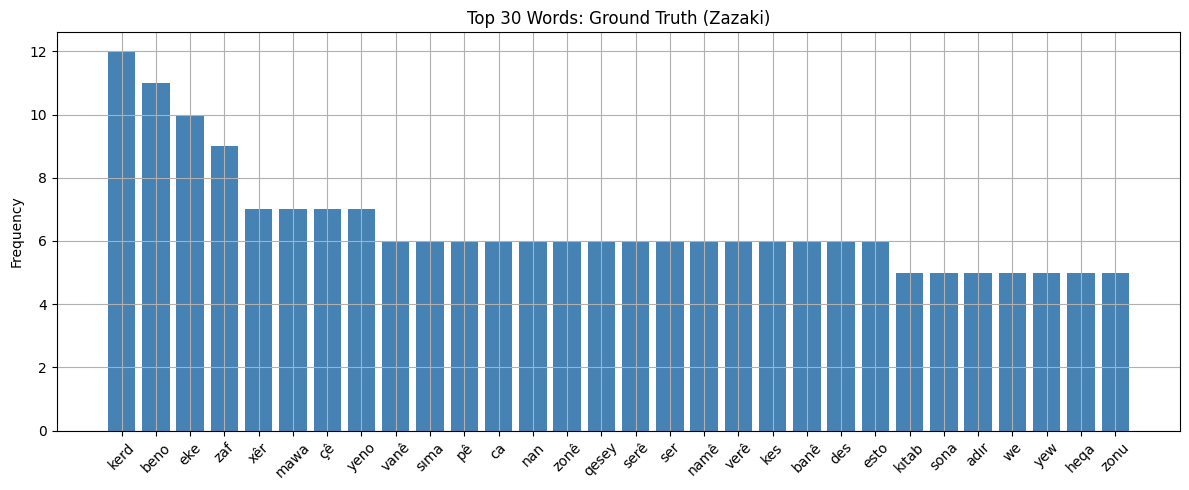

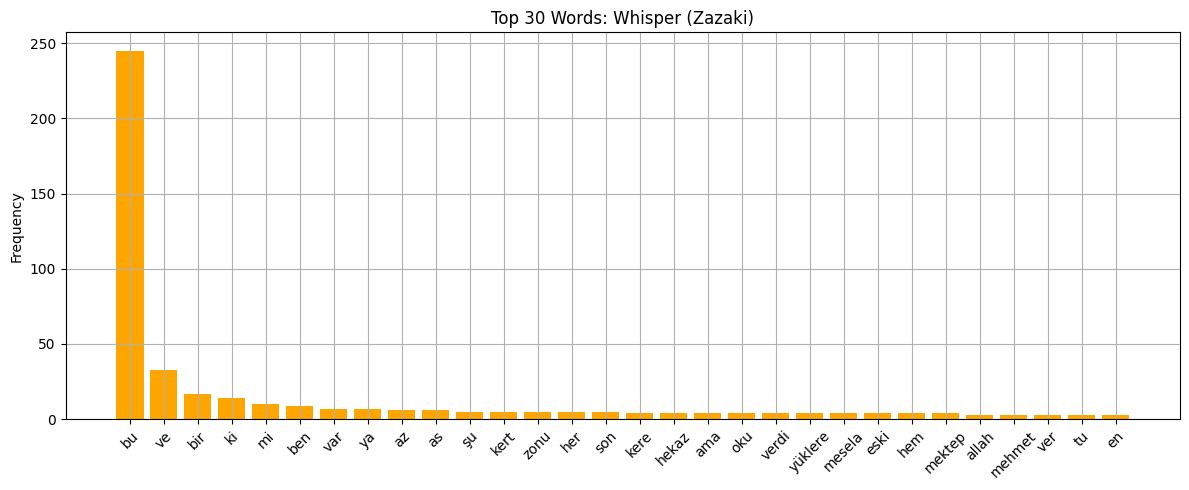

In [44]:
# ✅ Cell 8: Top-30 Bar Plots
def plot_top_words(counter, title, color):
    top_words = counter.most_common(30)
    words, freqs = zip(*top_words)
    plt.figure(figsize=(12, 5))
    plt.bar(words, freqs, color=color)
    plt.xticks(rotation=45)
    plt.title(f"Top 30 Words: {title}")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_top_words(gt_counts, "Ground Truth (Zazaki)", "steelblue")
plot_top_words(whisper_counts, "Whisper (Zazaki)", "orange")
if w2v2_counts:
    plot_top_words(w2v2_counts, "Wav2Vec2 (Zazaki)", "green")


In [45]:
# 🔍 Extra Analysis: Compare top-30 words before and after stopword removal
def get_counts_without_stopwords(texts):
    tokens = []
    for t in texts:
        tokens.extend(normalize_text(t).split())  # no stopword filtering
    return Counter(tokens)

gt_counts_no_filter = get_counts_without_stopwords(df_clean["ground_truth"])

# Compare top 30 words
top_with_stopwords = [w for w, _ in gt_counts_no_filter.most_common(30)]
top_without_stopwords = [w for w, _ in gt_counts.most_common(30)]

print("🆚 Top words before stopword removal:", top_with_stopwords)
print("✅ Top words after stopword removal:", top_without_stopwords)

overlap = len(set(top_with_stopwords) & set(top_without_stopwords)) / len(top_with_stopwords)
print(f"🔁 Overlap (with vs without stopwords): {overlap:.2f}")


🆚 Top words before stopword removal: ['ra', 'de', 'xo', 'ez', 'ma', 'to', 'mı', 'ke', 'u', 'ro', 'bo', 'tı', 'rê', 'o', 'a', 'na', 'be', 'kerd', 'bi', 'beno', 'eke', 'keno', 'ey', 'zaf', 'kena', 'kenê', 'kay', 'da', 'no', 'xêr']
✅ Top words after stopword removal: ['kerd', 'beno', 'eke', 'zaf', 'xêr', 'mawa', 'çê', 'yeno', 'vanê', 'sıma', 'pê', 'ca', 'nan', 'zonê', 'qesey', 'serê', 'ser', 'namê', 'verê', 'kes', 'banê', 'des', 'esto', 'kıtab', 'sona', 'adır', 'we', 'yew', 'heqa', 'zonu']
🔁 Overlap (with vs without stopwords): 0.17
